In [29]:
'''given ra, dec of RRL tracers produce business card plot for that candidate'''

#imports

from __future__ import division
from astropy.io import fits
import numpy as np
import matplotlib
from matplotlib import pylab, mlab, pyplot
from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs
from pylab import *
from numpy import *
import scipy
import matplotlib.pyplot as pyplot
import scipy.integrate
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
from matplotlib import gridspec
import scipy.optimize
from scipy.optimize import minimize
import scipy.stats
import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import rc
from astropy.visualization import simple_norm
from astropy.table import Table
from scipy.optimize import curve_fit
from matplotlib.ticker import EngFormatter, StrMethodFormatter
import csv
from astropy import wcs
from astropy.io import fits
import datetime
import sys
import statistics
from scipy import ndimage, misc
import scipy.optimize as opt
from scipy.ndimage.measurements import label
from scipy.special import kv
from scipy.special import iv
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import sqlutilpy
import healpy as hp
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5  
from astropy.coordinates import Angle, Latitude, Longitude 
import matplotlib.patches as patches
import sfdmap
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell
from astropy import units as u
from matplotlib.path import Path

rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
            
print(find_notebook('Cke_tools'))

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

    
sys.meta_path.append(NotebookFinder())


def lorentzian( x, x0, a, gam ):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2)


import Cke_tools as cke 

Cke_tools.ipynb


In [17]:
RRL_path = '/data/cke23/RRL_data/' # location of files 

In [18]:
# healpix definitions

nside = 64 
print("Approximate resolution at NSIDE {} is {:.2} deg".format(nside, hp.nside2resol(nside, arcmin=True) / 60))

npix = hp.nside2npix(nside) 
print('number of pixels = {}'.format(npix))

Approximate resolution at NSIDE 64 is 0.92 deg
number of pixels = 49152


In [19]:
# read in catalog of RRL stars with d > min distance and indexed by healpix index at nside

dist_min = 30 #can change the minimum distance beyond which we look for RRL stars
dist_cut_stars_indexed = 'nside_'+str(nside)+'_>'+str(dist_min)+'kpc_RRL_dist.fits'

hdul_data = fits.open(RRL_path+dist_cut_stars_indexed) 
data = hdul_data[1].data 
data_header = hdul_data[1].header 
data_cols = hdul_data[1].columns 
hdul_data.close()

RRL_dist_kpc = data.field('DIST') 
RRL_ra = data.field('RA') 
RRL_dec = data.field('DEC')
RRL_pmra = data.field('PMRA') 
RRL_pmdec = data.field('PMDEC') 
RRL_pmra_err = data.field('PMRA_ERROR') 
RRL_pmdec_err = data.field('PMDEC_ERROR') 
RRL_ebv = data.field('EBV') 
RRL_pixels = data.field('PIXEL')

RRL_data_array = np.zeros((9,len(RRL_dist_kpc)))
RRL_data_array[0,:]=RRL_dist_kpc
RRL_data_array[1,:]=RRL_ra
RRL_data_array[2,:]=RRL_dec
RRL_data_array[3,:]=RRL_pmra
RRL_data_array[4,:]=RRL_pmdec
RRL_data_array[5,:]=RRL_pmra_err
RRL_data_array[6,:]=RRL_pmdec_err
RRL_data_array[7,:]=RRL_ebv
RRL_data_array[8,:]=RRL_pixels

NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


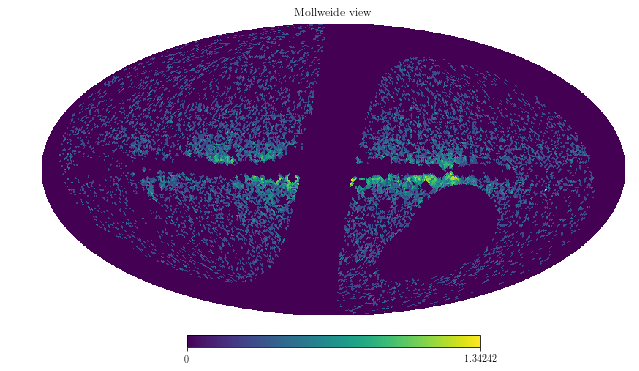

In [20]:
# read in healpix map of all stars d > min distance but with masks applied

healpix_path = '/data/cke23/healpix_maps/' # location of files 
RRL_hp_map_masked_sag = '>'+str(dist_min)+'kpc_RRL_map_satellites_sag_masked.fits'


RRL_map_masked_sag = hp.read_map(healpix_path + RRL_hp_map_masked_sag)
hp.mollview(np.log10(RRL_map_masked_sag+1))

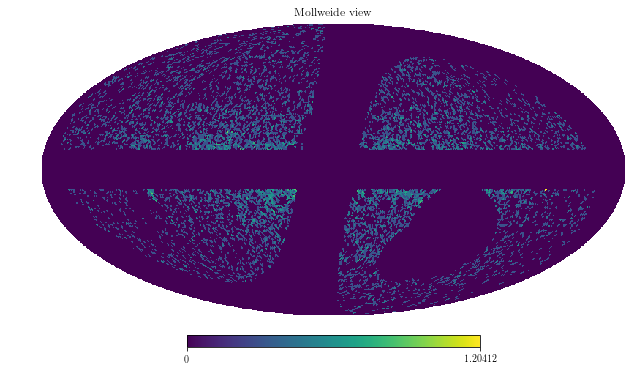

In [21]:
### mask the galactic plane ##

gplane_mask = [80,100] #change depending on how much of galactic plane we want masked

RRL_map_masked_sag_gplane = RRL_map_masked_sag*1
theta_map, phi_map = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
RRL_map_masked_sag_gplane[(theta_map>=np.deg2rad(gplane_mask[0])) & (theta_map<=np.deg2rad(gplane_mask[1]))]=0 #mask out a large region of the galactic plane for now
hp.mollview(np.log10(RRL_map_masked_sag_gplane+1))
RRL_hp_map_masked_sag_gplane  = '>'+str(dist_min)+'kpc_RRL_map_satellites_sag_gplane_masked.fits'
hp.write_map(healpix_path+RRL_hp_map_masked_sag_gplane, RRL_map_masked_sag_gplane, overwrite=True)

In [22]:
# find pixels with 2 or more stars

ind_2stars = [i for i, x in enumerate(RRL_map_masked_sag_gplane) if  x >= 2] 
print(
    "There are {} pixels containing >= 2 stars".format(len(ind_2stars))
)
print(
    "There are {} stars in these pixels".format(int(np.sum(RRL_map_masked_sag_gplane[ind_2stars])))
) #how many stars in total are there within these pixels 



There are 1700 pixels containing >= 2 stars
There are 3940 stars in these pixels


In [23]:
# get hp indices of these pixels and corresponding RA, Dec 

thetas, phis = hp.pix2ang(nside, ind_2stars)
ls, bs = np.rad2deg(phis), np.rad2deg(np.pi/2-thetas)
eqs = SkyCoord(frame='galactic', l=ls, b=bs, unit='deg')
ras, decs = eqs.icrs.ra.value, eqs.icrs.dec.value

In [24]:
# combine adjacent pixels with 2 or more stars into clumps

catalog = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)

idxs, d2d, d3d = catalog.match_to_catalog_sky(catalog)
idx1, idx2, sep2d, dist3d = catalog.search_around_sky(catalog, 1*u.deg) #for each star get stars that are within 1 deg

clumps = []
for i in range(len(idx1)):
    if idx1[i] != idx2[i]: #dont include match to itself 
        clumps.append((idx1[i], idx2[i])) #append tuples separated by less than 1 deg 

d=clumps
temp = []
for a,b in d :
    if (a,b) not in temp and (b,a) not in temp: #removes duplicate tuples not in same order (a,b),(b,a)
        temp.append((a,b))
d = temp * 1 #copy temp to d

tuple_list=d
iset = set([frozenset(s) for s in tuple_list])  # Convert to a set of sets
result = []
while(iset):                  # While there are sets left to process:
    nset = set(iset.pop())      # Pop a new set
    check = len(iset)           # Does iset contain more sets
    while check:                # Until no more sets to check:
        check = False
        for s in iset.copy():       # For each other set:
            if nset.intersection(s):  # if they intersect:
                check = True            # Must recheck previous sets
                iset.remove(s)          # Remove it from remaining sets
                nset.update(s)          # Add it to the current set
    result.append(tuple(nset))  # Convert back to a list of tuples
print(len(result),'number of clumps')


counter = 0 
stars_in_clumps = [item for t in result for item in t] 
print(len(stars_in_clumps), 'stars in clumps')
for i in range(len(result)):
    counter = counter + len(result[i])

stars_not_clumped = [x for x in idxs if x not in stars_in_clumps]
print(len(stars_not_clumped), 'stars not in clumps')

grouped = np.concatenate((stars_not_clumped, result))

210 number of clumps
721 stars in clumps
979 stars not in clumps


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [32]:
######################################### selection cuts #########################################

max_parallax = 0.5
ra_cent, dec_cent, spatial_radius = 0, 0, 1.5
# pmra_cent, pmdec_cent, pm_radius = 0, 0, 1.5

#vertices of colour mask
bp_rp_vertices = [0.8,1.2,1.8,1] 
abs_g_vertices = [1.5,1.5,-3.5,-3.5]

#look at having multiple colour masks i can swap in and out
#but how do i automate this without explicitly calculating metallicity

parallax_id = 'p_'+str(max_parallax)+'_'
sd_id = 'sd_'+str(ra_cent)+'_'+str(dec_cent)+'_'+str(spatial_radius)+'_'
bprp_id = 'bp_rp_'+str(bp_rp_vertices[0])+'_'+str(bp_rp_vertices[1])+'_'+str(bp_rp_vertices[2])+'_'+str(bp_rp_vertices[3])+'_'
g_id = 'g_'+str(abs_g_vertices[0])+'_'+str(abs_g_vertices[1])+'_'+str(abs_g_vertices[2])+'_'+str(abs_g_vertices[3])+'_'
# pm_id = 'pm_'+str(pmra_cent)+'_'+str(pmdec_cent)+'_'+str(pm_radius)
pm_id = 'pm_mean_RRLpmra_RRLpmdec_1.5'

folder_name = parallax_id + sd_id + bprp_id + g_id + pm_id


In [33]:
######################################### plotting parameters #########################################

cmap_plots = 'viridis'

#bins for histograms, same number in each dimension
sd_bins, cmd_bins, pm_bins = [100,100], [100,100], [100,100] 
sd_bins_cuts, cmd_bins_cuts, pm_bins_cuts = [25,25], [25,25], [25,25]

#plot ranges before selection cuts
sd_range = [[-5, 5], [-5, 5]]
cmd_range = [[0, 2], [-9, 3]]
pm_range = [[-8, 4], [-4, 8]]

#plot ranges after selection cuts
sd_range_cuts = [[-5, 5], [-5, 5]]
cmd_range_cuts = [[0, 2], [-9, 3]]
pm_range_cuts = [[-8, 4], [-4, 8]]

axis_fontsize = 12

In [34]:
# feed in ra, dec here and identify corresponding RRL tracer

ra_tracer, dec_tracer = 19.1, -41.2 #change here
vec_tracer = cke.radec2vec(ra_tracer, dec_tracer)
# print(vec_tracer)
pix_tracer = hp.vec2pix(nside,vec_tracer[0],vec_tracer[1],vec_tracer[2])
# print(pix_tracer)
# print(grouped)
# print(stars_not_clumped)
# print(stars_in_clumps)
# print(idx1)
# print(catalog[0])
# print(np.round(catalog[0],decimals=1))
# import astropy.coordinates as coord
# objecttest = catalog[0]
# print(objecttest)
# print(type(objecttest))
# print(objecttest.ra.degree)
# ra = coord.Angle(objecttest["ra"], unit=u.hour) # create an Angle object
# ra.degree # convert to degrees

# for all catalog indexes in grouped, convert to ra dec rounded to 1 dp.
# grouped_coordinates = []
# for i in range(len(grouped)):
#     group = grouped[i]
#     if type(group) == int:
#         print(i, group)
#         ra_group, dec_group = (catalog[array(group)]).ra.degree, (catalog[array(group)]).dec.degree
#         print(ra_group,dec_group)
#     else:
#         print(group)
#         print(type(group))
#         print(array(group))
#         print(catalog[array(group)].ra.degree)
        
# print(type(grouped))


resultlist = [(np.round(np.median((ras[array(item)])),decimals=1),np.round(np.median((decs[array(item)])),decimals=1)) for item in grouped]

# print(resultlist)

coord_search = []
#this is really slow how can i make it quicker
for i in range(len(grouped)): # len(grouped)
    if type(grouped[i]) == int: # not a clump only 1 pixel
        ra_pixel, dec_pixel = (np.array(ras))[grouped[i]], (np.array(decs))[grouped[i]]
        vec_pixel = cke.radec2vec(ra_pixel, dec_pixel)
        pixel_ind = [hp.vec2pix(nside, vec_pixel[0], vec_pixel[1], vec_pixel[2])]         
    else: # multiple pixels in a clump
        ra_pixel, dec_pixel = (np.array(ras))[list(grouped[i])], (np.array(decs))[list(grouped[i])]
        vec_pixel = cke.radec2vec(ra_pixel, dec_pixel)
        pixel_ind = hp.vec2pix(nside, vec_pixel[:,0], vec_pixel[:,1], vec_pixel[:,2]) 
        
#     print(ra_pixel, dec_pixel)
    num_pixels, num_stars = len(pixel_ind), int(np.sum(RRL_map_masked_sag[pixel_ind]))
    pixel_ind = np.array(pixel_ind)
    RRL_data_idx = np.hstack([(RRL_pixels==j).nonzero()[0] for j in pixel_ind])
    plot_data = RRL_data_array[:,RRL_data_idx]
    pixel_avgs = np.median(plot_data, axis=1)
    
    ra_text, dec_text = (np.round(pixel_avgs[1],decimals=1)), (np.round(pixel_avgs[2],decimals=1))
    coord_search.append((ra_text, dec_text))

    
print(coord_search[381])    
TupList = coord_search
trace_ind = TupList.index((ra_tracer,dec_tracer))
print(trace_ind)
    

(159.3, -35.9)
1000


1000


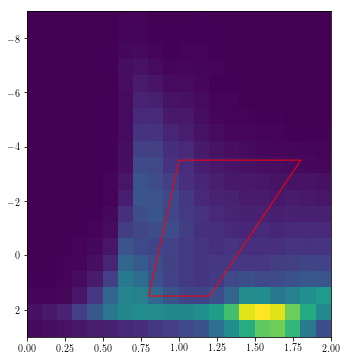

MemoryError: Unable to allocate 499. GiB for an array with shape (258733, 258733) and data type float64

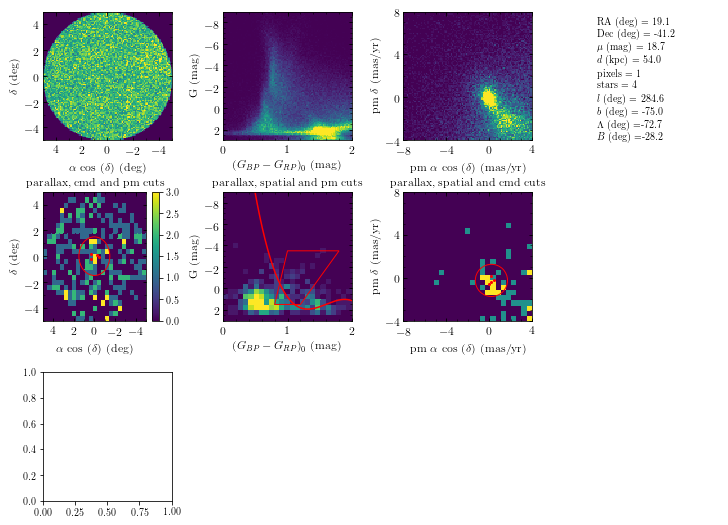

In [55]:
### using tracer do a substructure search ###

### need to add new colour cuts etc to here before i run properly

for i in range(1): # len(grouped)
    i = trace_ind
    print(i)
    
    if type(grouped[i]) == int: # not a clump only 1 pixel
        ra_pixel, dec_pixel = (np.array(ras))[grouped[i]], (np.array(decs))[grouped[i]]
        vec_pixel = cke.radec2vec(ra_pixel, dec_pixel)
        pixel_ind = [hp.vec2pix(nside, vec_pixel[0], vec_pixel[1], vec_pixel[2])]  
        
    else: # multiple pixels in a clump
        ra_pixel, dec_pixel = (np.array(ras))[list(grouped[i])], (np.array(decs))[list(grouped[i])]
        vec_pixel = cke.radec2vec(ra_pixel, dec_pixel)
        pixel_ind = hp.vec2pix(nside, vec_pixel[:,0], vec_pixel[:,1], vec_pixel[:,2]) 
        
    num_pixels, num_stars = len(pixel_ind), int(np.sum(RRL_map_masked_sag[pixel_ind]))
    pixel_ind = np.array(pixel_ind)
    RRL_data_idx = np.hstack([(RRL_pixels==j).nonzero()[0] for j in pixel_ind])
    plot_data = RRL_data_array[:,RRL_data_idx]
    pixel_avgs = np.median(plot_data, axis=1)
    pixel_avgs_mean = np.mean(plot_data, axis=1)
    pixel_stdev = np.std(plot_data, axis=1)
    
    pmra_cent, pmdec_cent, pm_radius = pixel_avgs_mean[3], pixel_avgs_mean[4], 1.5
    
    RRL_u_avg = cke.dist2distmod(pixel_avgs[0]) # distance modulus used to calculate abs mag
    ra_text, dec_text = str(np.round(pixel_avgs[1],decimals=1)), str(np.round(pixel_avgs[2],decimals=1))
    candidates = '/home/cke23/Documents/individual_candidates/'
    ra_dec_folder_name = 'ra_'+ra_text+'_dec_'+dec_text
    ra_dec_plot_directory = candidates+ra_dec_folder_name
    if not os.path.exists(ra_dec_plot_directory):
       os.makedirs(ra_dec_plot_directory)
    
    
    
    #query GAIA within WSDB around tracer
    GAIA_ra,GAIA_dec,GAIA_pmra,GAIA_pmra_err,GAIA_pmdec,GAIA_pmdec_err,GAIA_para,GAIA_g,GAIA_bp_rp,GAIA_ebv=sqlutilpy.get(
            """SELECT g.ra,g.dec,g.pmra,g.pmra_error,g.pmdec,g.pmdec_error,g.parallax,g.phot_g_mean_mag,g.bp_rp,g.ebv
            FROM gaia_edr3.gaia_source AS g 
            WHERE q3c_radial_query(g.ra, g.dec, """ + ra_text + """, """ + dec_text + """, 5)
            """,
        db='wsdb',host='cappc127.ast.cam.ac.uk', user='chloe_ellerton', password='sfCy6?Bx')
    
    ra_plot, dec_plot = (GAIA_ra - pixel_avgs[1])*cos(np.deg2rad(pixel_avgs[2])), GAIA_dec - pixel_avgs[2]
    bp_rp_0 = GAIA_bp_rp-(cke.dust_corr(GAIA_bp_rp, GAIA_ebv))[1]
    app_g_0 = GAIA_g-(cke.dust_corr(GAIA_bp_rp, GAIA_ebv))[0]
    abs_g_0 = app_g_0 - RRL_u_avg
    
    #define what each selection cut does
    parallax_cut = (GAIA_para <= max_parallax)
    spatial_cut = (((ra_plot-ra_cent)**2) + ((dec_plot-dec_cent)**2) <= spatial_radius**2) 
    pm_cut = ((GAIA_pmra-pmra_cent)**2 + (GAIA_pmdec-pmdec_cent)**2 <= pm_radius**2)
    
    # from vertices in colour magnitude plane, calculate equations of the lines to use as selection cuts
    grad1 = (abs_g_vertices[3] - abs_g_vertices[0]) / (bp_rp_vertices[3] - bp_rp_vertices[0]) 
    int1 = abs_g_vertices[0] - (grad1*bp_rp_vertices[0])
    grad2 = (abs_g_vertices[2] - abs_g_vertices[1]) / (bp_rp_vertices[2] - bp_rp_vertices[1]) 
    int2 =  abs_g_vertices[1] - (grad2*bp_rp_vertices[1])
    colour_cut = ((abs_g_0 >= abs_g_vertices[3]) & (abs_g_0 <= abs_g_vertices[0]) & (abs_g_0 <= (grad2*GAIA_bp_rp) + int2) & (abs_g_0 >= (grad1*GAIA_bp_rp) + int1))
    
    #hess difference calculations
    aperture_ra_cent, aperture_dec_cent, aperture_spatial_radius = 0, 0, 1.5
    aperture_spatial_cut = (((ra_plot-aperture_ra_cent)**2) + ((dec_plot-aperture_dec_cent)**2) <= aperture_spatial_radius**2)
    inner_aperture_cut = np.argwhere(parallax_cut & pm_cut & aperture_spatial_cut)

    annulus_inner_radius, annulus_outer_radius = 3, 4 
    annulus_inner_cut = (((ra_plot-aperture_ra_cent)**2) + ((dec_plot-aperture_dec_cent)**2) >= annulus_inner_radius**2)
    annulus_outer_cut = (((ra_plot-aperture_ra_cent)**2) + ((dec_plot-aperture_dec_cent)**2) <= annulus_outer_radius**2)
    annulus_cut = np.argwhere(annulus_inner_cut & annulus_outer_cut)

    values_bg,xbins_bg,ybins_bg = histogram2d((bp_rp_0[annulus_cut]).flatten(), (abs_g_0[annulus_cut]).flatten(), range=[[0,2], [-9,3]], bins=[25,25])
    values_fg,xbins_fg,ybins_fg = histogram2d((bp_rp_0[inner_aperture_cut]).flatten(), (abs_g_0[inner_aperture_cut]).flatten(), range=[[0,2], [-9,3]], bins=[25,25])
    hess_diff_values = ((values_fg/np.sum(values_fg))-(values_bg/np.sum(values_bg)))*np.sum(values_fg) 
 
    good_pixels = np.argwhere((hess_diff_values.T)>0)
    good_bin_edges = []
    for c in range(len(good_pixels)):
        y_i, x_i = (good_pixels[c])[0], (good_pixels[c])[1]
        ymin, ymax = ybins_fg[y_i], ybins_fg[y_i+1]
        xmin, xmax = xbins_fg[x_i], xbins_fg[x_i+1]
        good_bin_edges.append((xmin,xmax,ymin,ymax))

    color_mag = np.vstack((bp_rp_0, abs_g_0)).T
    mask_is = np.zeros(len(bp_rp_0))

    for d in range(len(good_bin_edges)):
        pixel_check = good_bin_edges[d]
        xmin,xmax,ymin,ymax = pixel_check[0],pixel_check[1],pixel_check[2],pixel_check[3]
        vertices = [(xmin,ymin),(xmax,ymin),(xmax,ymax),(xmin,ymax)]
        p = Path(vertices)
        #for each good pixel get all the stars inside and change mask values to 1
        # 1 = good, 0 = bad
        pixel_true_false = p.contains_points(color_mag) 
        mask_is[np.argwhere(pixel_true_false==True)] = 1
        
    hess_cut = (mask_is==1)
    
    bins_cmd_test = [20,20]
    fig = pyplot.figure(figsize=(12,6))
    gs = gridspec.GridSpec(1,2)
    ax1 = pyplot.subplot(gs[0]) 
    ax1.hist2d(bp_rp_0, abs_g_0, range=[[0,2], [-9,3]], bins=bins_cmd_test, cmap=cmap_plots)
    cmd_counts,cmd_x,cmd_y,_ = ax1.hist2d(bp_rp_0, abs_g_0, range=[[0,2], [-9,3]], bins=bins_cmd_test, cmap=cmap_plots)
    ax1.invert_yaxis()
    ax1.add_patch(patches.Polygon(xy=list(zip(bp_rp_vertices,abs_g_vertices)), fill=False, color='red')) #trying to visualise the colour mask
    pyplot.show()
#     cmd_counts,cmd_x,cmd_y=histogram2d(bp_rp_0[annulus_cut].flatten(), abs_g_0[annulus_cut].flatten(), range=[[0,2], [-9,3]], bins=bins_cmd_test)

    turnovers = []
    positions = []
    for k in range(int((bins_cmd_test[0])/2)):
        k=k+int((bins_cmd_test[0])/2) #only look at second half of cmd
        y_values=[]
        count_values=[]
        for m in range(bins_cmd_test[0]):
            y_values.append(m)
            count_values.append(cmd_counts[k,m])

        sigma = 15 #maybe this needs some work..
        gamma = 15
        centre = y_values[np.argmax(count_values)]
        x=y_values
        y=count_values
        popt, pcov = curve_fit(lorentzian, x, y, p0=[centre, (np.max(y)-np.min(y)), gamma], maxfev=10000)
        turnover = popt[0]-(popt[2]/2)
        turnovers.append(turnover)
        positions.append(k)
#         pyplot.plot(y_values,count_values)
#         pyplot.plot(x, lorentzian(x, *popt), 'r-', label='fit')
        
#     pyplot.show()
    pfit = np.polyfit(array(positions)/10, ((array(turnovers)*12)/20)-9, 3)
    poly = np.poly1d(pfit)
#     fig = pyplot.figure(figsize=(12,6))
#     gs = gridspec.GridSpec(1,2)
#     ax1 = pyplot.subplot(gs[0]) 
#     ax1.hist2d(bp_rp_0, abs_g_0, range=[[0,2], [-9,3]], bins=bins_cmd_test, cmap=cmap_plots)
#     cmd_counts,cmd_x,cmd_y,_ = ax1.hist2d(bp_rp_0, abs_g_0, range=[[0,2], [-9,3]], bins=bins_cmd_test, cmap=cmap_plots)
#     ax1.invert_yaxis()
#     ax1.add_patch(patches.Polygon(xy=list(zip(bp_rp_vertices,abs_g_vertices)), fill=False, color='red')) #trying to visualise the colour mask
# #     ax1.plot(np.arange(0,2,0.01), poly(np.arange(0,2,0.01)))
#     ax1.plot(array(positions)/10, ((array(turnovers)*12)/20)-9,'.')


#     pyplot.show()
    

    colour_cut_ms = (abs_g_0 <= poly(bp_rp_0))
    
    
    fig = pyplot.figure(figsize=(12,9))
    gs = gridspec.GridSpec(3, 4, width_ratios=[1,1,1,1], height_ratios=[1,1,1], wspace=0.4, hspace=0.4)
    
    #top row is all GAIA stars without selection cuts
    ax0 = pyplot.subplot(gs[0])      
    ax1 = pyplot.subplot(gs[1])    
    ax2 = pyplot.subplot(gs[2]) 

    #stellar density 
    counts0, _, _, im0 = ax0.hist2d((ra_plot), (dec_plot),range=sd_range, bins=sd_bins, cmap=cmap_plots)
    #stretching the colourmap, is there a better way to do this?
    _, _, _, im0 = ax0.hist2d((ra_plot), (dec_plot),range=sd_range, bins=sd_bins, norm=matplotlib.colors.Normalize(vmin=np.percentile(counts0, 1), vmax=np.percentile(counts0, 99)), cmap=cmap_plots)

    ax0.invert_xaxis()
    ax0.set_ylabel(r'$\delta$ (deg)', fontsize=axis_fontsize)
    ax0.set_xlabel(r'$\alpha$ cos ($\delta$) (deg)', fontsize=axis_fontsize)
    ax0.tick_params(axis='both', which='both', direction='in', bottom=True, top=True, left=True, right=True, labelsize=axis_fontsize)
    ax0.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax0.yaxis.set_major_locator(ticker.MultipleLocator(2))
    ax0.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax0.yaxis.set_minor_locator(ticker.MultipleLocator(1))

    #colour magnitude
    counts1, _, _, im1 = ax1.hist2d(bp_rp_0, abs_g_0, range=cmd_range, bins=cmd_bins, cmap=cmap_plots)
    _, _, _, im1 = ax1.hist2d(bp_rp_0, abs_g_0, range=cmd_range, bins=cmd_bins, norm=matplotlib.colors.Normalize(vmin=np.percentile(counts1, 1), vmax=np.percentile(counts1, 99)), cmap=cmap_plots)
    ax1.invert_yaxis()
    ax1.set_ylabel('G (mag)', fontsize=axis_fontsize)
    ax1.set_xlabel(r'${(G_{BP} - G_{RP})}_{0}$ (mag)', fontsize=axis_fontsize)
    ax1.tick_params(axis='both', which='both', direction='in', bottom=True, top=True, left=True, right=True, labelsize=axis_fontsize)
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(2))
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
    
    #proper motion 
    counts2, _, _, im2 = ax2.hist2d(GAIA_pmra, GAIA_pmdec, range=pm_range, bins=pm_bins, cmap=cmap_plots)
    _, _, _, im2 = ax2.hist2d(GAIA_pmra, GAIA_pmdec, range=pm_range, bins=pm_bins, norm=matplotlib.colors.Normalize(vmin=np.percentile(counts2, 1), vmax=np.percentile(counts2, 99)), cmap=cmap_plots)
    ax2.set_ylabel(r'pm $\delta$ (mas/yr)', fontsize=axis_fontsize)
    ax2.set_xlabel(r'pm $\alpha$ cos ($\delta$) (mas/yr)', fontsize=axis_fontsize)
    ax2.tick_params(axis='both', which='both', direction='in', bottom=True, top=True, left=True, right=True, labelsize=axis_fontsize)
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(4))
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(4))
    ax2.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax2.yaxis.set_minor_locator(ticker.MultipleLocator(1))


    #middle row is all GAIA stars with selection cuts 
    #all panels have a parallax cut
    ax00 = pyplot.subplot(gs[4])      
    ax11 = pyplot.subplot(gs[5])    
    ax22 = pyplot.subplot(gs[6]) 

    #stellar density with proper motion and colour magnitude cuts
    sd_plot_cuts = np.argwhere(parallax_cut & pm_cut & colour_cut& colour_cut_ms & hess_cut)
    counts00, _, _, im00 = ax00.hist2d((ra_plot[sd_plot_cuts]).flatten(), (dec_plot[sd_plot_cuts]).flatten(),range=sd_range_cuts, bins=sd_bins_cuts, cmap=cmap_plots)
    _, _, _, im00 = ax00.hist2d((ra_plot[sd_plot_cuts]).flatten(), (dec_plot[sd_plot_cuts]).flatten(),range=sd_range_cuts, bins=sd_bins_cuts,norm=matplotlib.colors.Normalize(vmin=np.percentile(counts00, 1), vmax=np.percentile(counts00, 99)), cmap=cmap_plots)
    fig.colorbar(im00, ax=ax00) 
    ax00.invert_xaxis()
    ax00.set_ylabel(r'$\delta$ (deg)', fontsize=axis_fontsize)
    ax00.set_xlabel(r'$\alpha$ cos ($\delta$) (deg)', fontsize=axis_fontsize)
    circlesd = pyplot.Circle((ra_cent, dec_cent), spatial_radius, color='r', fill=False)
    ax00.add_artist(circlesd)
    ax00.set_title('parallax, cmd and pm cuts', size=axis_fontsize)
    ax00.plot(plot_data[1,:]-pixel_avgs[1], plot_data[2,:]-pixel_avgs[2], 'ro', markersize=2)
    ax00.tick_params(axis='both', which='both', direction='in', bottom=True, top=True, left=True, right=True, labelsize=axis_fontsize)
    ax00.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax00.yaxis.set_major_locator(ticker.MultipleLocator(2))
    ax00.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax00.yaxis.set_minor_locator(ticker.MultipleLocator(1))

    #colour magnitude with spatial and proper motion cuts 
    cmd_plot_cuts = np.argwhere(parallax_cut & spatial_cut & pm_cut)
    counts11, _, _, im11 = ax11.hist2d((bp_rp_0[cmd_plot_cuts]).flatten(), (abs_g_0[cmd_plot_cuts]).flatten(), range=cmd_range_cuts, bins=cmd_bins_cuts, cmap=cmap_plots)
    _, _, _, im11 = ax11.hist2d((bp_rp_0[cmd_plot_cuts]).flatten(), (abs_g_0[cmd_plot_cuts]).flatten(), range=cmd_range_cuts, bins=cmd_bins_cuts,norm=matplotlib.colors.Normalize(vmin=np.percentile(counts11, 1), vmax=np.percentile(counts11, 99)), cmap=cmap_plots)

    
    ax11.invert_yaxis()
    ax11.set_ylabel('G (mag)', fontsize=axis_fontsize)
    ax11.set_xlabel(r'${(G_{BP} - G_{RP})}_{0}$ (mag)', fontsize=axis_fontsize)
    ax11.add_patch(patches.Polygon(xy=list(zip(bp_rp_vertices,abs_g_vertices)), fill=False, color='red')) #trying to visualise the colour mask
    ax11.set_title('parallax, spatial and pm cuts', size=axis_fontsize)
    ax11.tick_params(axis='both', which='both', direction='in', bottom=True, top=True, left=True, right=True, labelsize=axis_fontsize)
    ax11.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax11.yaxis.set_major_locator(ticker.MultipleLocator(2))
    ax11.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
    ax11.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
    ax11.plot(np.arange(0,2,0.01), poly(np.arange(0,2,0.01)),'red')

    #proper motion with spatial and colour magnitdue cuts
    pm_plot_cuts = np.argwhere(parallax_cut & spatial_cut & colour_cut &  colour_cut_ms & hess_cut)
    counts22, _, _, im22 = ax22.hist2d((GAIA_pmra[pm_plot_cuts]).flatten(), (GAIA_pmdec[pm_plot_cuts]).flatten(), range=pm_range_cuts, bins=pm_bins_cuts, cmap=cmap_plots)
    _, _, _, im22 = ax22.hist2d((GAIA_pmra[pm_plot_cuts]).flatten(), (GAIA_pmdec[pm_plot_cuts]).flatten(), range=pm_range_cuts, bins=pm_bins_cuts, norm=matplotlib.colors.Normalize(vmin=np.percentile(counts22, 1), vmax=np.percentile(counts22, 99)), cmap=cmap_plots)
    
    ax22.set_ylabel(r'pm $\delta$ (mas/yr)', fontsize=axis_fontsize)
    ax22.set_xlabel(r'pm $\alpha$ cos ($\delta$) (mas/yr)', fontsize=axis_fontsize)
    circlepm = pyplot.Circle((pmra_cent, pmdec_cent), pm_radius, color='r', fill=False)
    ax22.add_artist(circlepm)
    ax22.set_title('parallax, spatial and cmd cuts', size=axis_fontsize)
    ax22.plot(plot_data[3,:], plot_data[4,:], 'ro', markersize=2)
    ax22.tick_params(axis='both', which='both', direction='in', bottom=True, top=True, left=True, right=True, labelsize=axis_fontsize)
    ax22.xaxis.set_major_locator(ticker.MultipleLocator(4))
    ax22.yaxis.set_major_locator(ticker.MultipleLocator(4))
    ax22.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax22.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    
    
    ax3 = pyplot.subplot(gs[3])
    ax3.axis('off')


    ax3.text(0.1, 0.9, 'RA (deg) = ' + str(np.round(pixel_avgs[1],decimals=1)), transform=pyplot.gca().transAxes, fontsize=10) 
    ax3.text(0.1, 0.8, 'Dec (deg) = ' + str(np.round(pixel_avgs[2],decimals=1)), transform=pyplot.gca().transAxes, fontsize=10)  
    ax3.text(0.1, 0.7, '$\mu$ (mag) = ' + str(np.round(RRL_u_avg,decimals=1)), transform=pyplot.gca().transAxes, fontsize=10) 
    ax3.text(0.1, 0.6, '$d$ (kpc) = ' + str(np.round(pixel_avgs[0],decimals=1)), transform=pyplot.gca().transAxes, fontsize=10)
    ax3.text(0.1, 0.5, 'pixels = ' + str(1), transform=pyplot.gca().transAxes, fontsize=10)
    ax3.text(0.1, 0.4, 'stars = ' + str(int(num_stars)), transform=pyplot.gca().transAxes, fontsize=10)
    ax3.text(0.1, 0.3, '$l$ (deg) = ' + str(np.round((SkyCoord(pixel_avgs[1],pixel_avgs[2],unit='deg')).galactic.l.value, decimals=1)), transform=pyplot.gca().transAxes, fontsize=10)
    ax3.text(0.1, 0.2, '$b$ (deg) = ' + str(np.round((SkyCoord(pixel_avgs[1],pixel_avgs[2],unit='deg')).galactic.b.value, decimals=1)), transform=pyplot.gca().transAxes, fontsize=10)
    ax3.text(0.1, 0.1, '$\Lambda$ (deg) =' + str(np.round(np.rad2deg((cke.radec2sag_coord(pixel_avgs[1],pixel_avgs[2]))[0]),decimals=1)), transform=pyplot.gca().transAxes, fontsize=10)
    ax3.text(0.1, 0.0, '$B$ (deg) =' + str(np.round(np.rad2deg((cke.radec2sag_coord(pixel_avgs[1],pixel_avgs[2]))[1]),decimals=1)), transform=pyplot.gca().transAxes, fontsize=10)
    
    
    ax000 = pyplot.subplot(gs[8]) 
    yy, xx = np.meshgrid(ra_plot,dec_plot)
    ax000.pcolormesh(ra_plot, dec_plot, GAIA_ebv, xx,yy)
    ax111 = pyplot.subplot(gs[9])  
    ax111.plot(np.arange(0,2,0.01), poly(np.arange(0,2,0.01)),'red')
    ax111.imshow(hess_diff_values.T, vmin=0, extent=[0,2,3,-9], aspect=2/12)
    ax111.add_patch(patches.Polygon(xy=list(zip(bp_rp_vertices,abs_g_vertices)), fill=False, color='red')) #trying to visualise the colour mask
    ax111.set_title('hess diff $>$ 0', size=axis_fontsize)



    ax222 = pyplot.subplot(gs[10]) 
    ax222.axis('off')
    
    position_id = ra_text+'_'+dec_text+'_' #remove i as soon as i change galactic plane slice str(i)+'_'+
    parallax_id = 'p_'+str(max_parallax)+'_'
    sd_id = 'sd_'+str(ra_cent)+'_'+str(dec_cent)+'_'+str(spatial_radius)+'_'
    bprp_id = 'bp_rp'+str(bp_rp_vertices[0])+'_'+str(bp_rp_vertices[1])+'_'+str(bp_rp_vertices[2])+'_'+str(bp_rp_vertices[3])+'_'
    g_id = 'g'+str(abs_g_vertices[0])+'_'+str(abs_g_vertices[1])+'_'+str(abs_g_vertices[2])+'_'+str(abs_g_vertices[3])+'_'
#     pm_id = 'pm_'+str(pmra_cent)+'_'+str(pmdec_cent)+'_'+str(pm_radius)
    pm_id = 'pm_mean_RRLpmra_RRLpmdec_1.5'
    folder_name = parallax_id + sd_id + bprp_id + g_id + pm_id
    filename = position_id + folder_name
    path2fig2 = ra_dec_folder_name+'/'+filename+'.png'
    
    pyplot.savefig(candidates+path2fig2)
    print(candidates+path2fig2)
    pyplot.show()





In [ ]:
# # lets look at a global region and only apply CMD and proper motion cuts, see if we can see anything

# GAIA_ra,GAIA_dec,GAIA_pmra,GAIA_pmra_err,GAIA_pmdec,GAIA_pmdec_err,GAIA_para,GAIA_g,GAIA_bp_rp,GAIA_ebv=sqlutilpy.get(
#         """SELECT g.ra,g.dec,g.pmra,g.pmra_error,g.pmdec,g.pmdec_error,g.parallax,g.phot_g_mean_mag,g.bp_rp,g.ebv
#         FROM gaia_edr3.gaia_source AS g 
#         WHERE g.ra<200 and g.ra>150 and g.dec<0 and g.dec>-40
#         """,
#     db='wsdb',host='cappc127.ast.cam.ac.uk', user='chloe_ellerton', password='sfCy6?Bx')

In [ ]:
# #wait for gaia query to finish then run this bit

# ra_plot, dec_plot = (GAIA_ra - 175)*cos(np.deg2rad(-20)), GAIA_dec - (-20)
# bp_rp_0 = GAIA_bp_rp-(cke.dust_corr(GAIA_bp_rp, GAIA_ebv))[1]
# app_g_0 = GAIA_g-(cke.dust_corr(GAIA_bp_rp, GAIA_ebv))[0]
# abs_g_0 = app_g_0 - RRL_u_avg

# bp_rp_vertices = [0.8,1.2,2.1,1.2] 
# abs_g_vertices = [1,1,-4,-4]

# #define what each selection cut does
# parallax_cut = (GAIA_para <= max_parallax)
# spatial_cut = (((ra_plot-(-20))**2) + ((dec_plot-18)**2) <= 1.5**2) 
# pm_cut = ((GAIA_pmra-pmra_cent)**2 + (GAIA_pmdec-pmdec_cent)**2 <= 1.5**2)

# # from vertices in colour magnitude plane, calculate equations of the lines to use as selection cuts
# grad1 = (abs_g_vertices[3] - abs_g_vertices[0]) / (bp_rp_vertices[3] - bp_rp_vertices[0]) 
# int1 = abs_g_vertices[0] - (grad1*bp_rp_vertices[0])
# grad2 = (abs_g_vertices[2] - abs_g_vertices[1]) / (bp_rp_vertices[2] - bp_rp_vertices[1]) 
# int2 =  abs_g_vertices[1] - (grad2*bp_rp_vertices[1])
# colour_cut = ((abs_g_0 >= abs_g_vertices[3]) & (abs_g_0 <= abs_g_vertices[0]) & (abs_g_0 <= (grad2*GAIA_bp_rp) + int2) & (abs_g_0 >= (grad1*GAIA_bp_rp) + int1))

# fig = pyplot.figure(figsize=(12,12))
# gs = gridspec.GridSpec(2, 3, width_ratios=[1,1,1], height_ratios=[1,1], wspace=0.4, hspace=0.4)

# #top row is all GAIA stars without selection cuts
# ax0 = pyplot.subplot(gs[0])      
# counts0, _, _, im0 = ax0.hist2d((ra_plot), (dec_plot), bins=sd_bins, cmap=cmap_plots)
# #stretching the colourmap, is there a better way to do this?
# _, _, _, im0 = ax0.hist2d((ra_plot), (dec_plot),bins=sd_bins, norm=matplotlib.colors.Normalize(vmin=np.percentile(counts0, 1), vmax=np.percentile(counts0, 99)), cmap=cmap_plots)
# ax0.invert_xaxis()

# ax1 = pyplot.subplot(gs[1])  
# counts1, _, _, im1 = ax1.hist2d(bp_rp_0, abs_g_0, range=cmd_range, bins=cmd_bins, cmap=cmap_plots)
# _, _, _, im1 = ax1.hist2d(bp_rp_0, abs_g_0, range=cmd_range, bins=cmd_bins, norm=matplotlib.colors.Normalize(vmin=np.percentile(counts1, 1), vmax=np.percentile(counts1, 99)), cmap=cmap_plots)
# ax1.invert_yaxis()

# ax2 = pyplot.subplot(gs[2]) 
# counts2, _, _, im2 = ax2.hist2d(GAIA_pmra, GAIA_pmdec, range=pm_range, bins=pm_bins, cmap=cmap_plots)
# _, _, _, im2 = ax2.hist2d(GAIA_pmra, GAIA_pmdec, range=pm_range, bins=pm_bins, norm=matplotlib.colors.Normalize(vmin=np.percentile(counts2, 1), vmax=np.percentile(counts2, 99)), cmap=cmap_plots)



    
# #bottom row with parallax, cmd and pm cuts
# ax00 = pyplot.subplot(gs[3]) 

# sd_plot_cuts = np.argwhere(parallax_cut & pm_cut & colour_cut)
# counts00, _, _, im00 = ax00.hist2d((ra_plot[sd_plot_cuts]).flatten(), (dec_plot[sd_plot_cuts]).flatten(), bins=sd_bins, cmap=cmap_plots)
# _, _, _, im00 = ax00.hist2d((ra_plot[sd_plot_cuts]).flatten(), (dec_plot[sd_plot_cuts]).flatten(), bins=sd_bins,norm=matplotlib.colors.Normalize(vmin=np.percentile(counts00, 1), vmax=np.percentile(counts00, 99)), cmap=cmap_plots)
# # fig.colorbar(im00, ax=ax00) 
# ax00.invert_xaxis()
# circlesd1 = pyplot.Circle((-20, 18), 1.5, color='r', fill=False)
# ax00.add_artist(circlesd1)

# ax11 = pyplot.subplot(gs[4]) 
# cmd_plot_cuts = np.argwhere(parallax_cut & pm_cut & spatial_cut)
# counts11, _, _, im11 = ax11.hist2d((bp_rp_0[cmd_plot_cuts]).flatten(), (abs_g_0[cmd_plot_cuts]).flatten(), range=cmd_range_cuts, bins=cmd_bins_cuts, cmap=cmap_plots)
# _, _, _, im11 = ax11.hist2d((bp_rp_0[cmd_plot_cuts]).flatten(), (abs_g_0[cmd_plot_cuts]).flatten(), range=cmd_range_cuts, bins=cmd_bins_cuts,norm=matplotlib.colors.Normalize(vmin=np.percentile(counts11, 1), vmax=np.percentile(counts11, 99)), cmap=cmap_plots)
# ax11.invert_yaxis()
# ax11.add_patch(patches.Polygon(xy=list(zip(bp_rp_vertices,abs_g_vertices)), fill=False, color='red')) #trying to visualise the colour mask



# ax22 = pyplot.subplot(gs[5]) 
# pm_plot_cuts = np.argwhere(parallax_cut &  colour_cut & spatial_cut)
# counts22, _, _, im22 = ax22.hist2d((GAIA_pmra[pm_plot_cuts]).flatten(), (GAIA_pmdec[pm_plot_cuts]).flatten(), range=pm_range_cuts, bins=pm_bins_cuts, cmap=cmap_plots)
# _, _, _, im22 = ax22.hist2d((GAIA_pmra[pm_plot_cuts]).flatten(), (GAIA_pmdec[pm_plot_cuts]).flatten(), range=pm_range_cuts, bins=pm_bins_cuts, norm=matplotlib.colors.Normalize(vmin=np.percentile(counts22, 1), vmax=np.percentile(counts22, 99)), cmap=cmap_plots)
# circlepm1 = pyplot.Circle((pmra_cent, pmdec_cent), 1.5, color='r', fill=False)
# ax22.add_artist(circlepm1)
# pyplot.savefig('test_global.png')
# pyplot.show()



# fig = pyplot.figure(figsize=(12,12))
# gs = gridspec.GridSpec(2, 1, height_ratios=[1,1])

# ax0=pyplot.subplot(gs[0]) 
# counts0, _, _, im0 = ax0.hist2d((ra_plot), (dec_plot), bins=sd_bins, cmap=cmap_plots)
# #stretching the colourmap, is there a better way to do this?
# _, _, _, im0 = ax0.hist2d((ra_plot), (dec_plot),bins=sd_bins, norm=matplotlib.colors.Normalize(vmin=np.percentile(counts0, 1), vmax=np.percentile(counts0, 99)), cmap=cmap_plots)
# ax0.invert_xaxis()

# ax00=pyplot.subplot(gs[1]) 
# counts00, _, _, im00 = ax00.hist2d((ra_plot[sd_plot_cuts]).flatten(), (dec_plot[sd_plot_cuts]).flatten(), bins=sd_bins, cmap=cmap_plots)
# _, _, _, im00 = ax00.hist2d((ra_plot[sd_plot_cuts]).flatten(), (dec_plot[sd_plot_cuts]).flatten(), bins=sd_bins,norm=matplotlib.colors.Normalize(vmin=np.percentile(counts00, 1), vmax=np.percentile(counts00, 99)), cmap=cmap_plots)
# # fig.colorbar(im00, ax=ax00) 
# ax00.invert_xaxis()
# pyplot.savefig('test_global2.png')
# pyplot.show()